In [1]:
import numpy as np
import random
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import count
from matplotlib import cm

In [2]:
#geometry and meshing, here we use simple rectangular geometry. the meshes has dimension of h_x and h_y 
# this is the loosely coupled reactor problem taken from https://doi.org/10.1016/j.anucene.2011.12.032
#one can edit this section of the code to solve any fixed source 2D problem given that the geometry is rectangular

sigma_a = np.array([0.062158, 0.064256])
sigma_s = np.array([0.089302, 0.094853])
sigma_t = sigma_a+sigma_s
source = [0.01048083, 0.00214231]

azim = 16

X_max = 100
Y_max = 100
alpha = np.array([0,0,0,0])
h_x = 1
h_y = 1

num_of_mesh_x = int(X_max/h_x)
num_of_mesh_y = int(Y_max/h_y)
x_points = np.arange(0,X_max+h_x/2,h_x)
x_i = (x_points[0:-1]+x_points[1:])/2
y_points = np.arange(0,Y_max+h_y/2,h_y)
y_j = (y_points[0:-1]+y_points[1:])/2

true_area = h_x*h_y

sigma_t_i_j = np.zeros((num_of_mesh_x,num_of_mesh_y))
sigma_s_i_j = np.zeros((num_of_mesh_x,num_of_mesh_y))
source_i_j = np.zeros((num_of_mesh_x,num_of_mesh_y))

def material(x,y):
    return 0  if((10<=x and 10<=y and x<= 30 and y<= 30) or (70<=x and 70<=y and x<= 90 and y<= 90)) else 1 


for i in range(num_of_mesh_x):
    for j in range(num_of_mesh_y):
        mat = material(x_i[i], y_j[j])
        sigma_s_i_j[i,j] = sigma_s[mat]
        sigma_t_i_j[i,j] = sigma_t[mat]
        source_i_j[i,j] = source[mat] 

In [3]:
#tabuchi_yamamoto quadrature set
polar =3



sintheta_p = np.array([.166648, .537707, .932954])
theta_p = (np.arcsin(sintheta_p))

w_p = 2*(np.array([0.046233, 0.283619, 0.670148]))


#azimuthal angle the angles in the definition given in 3.79 from azman rafee


B = int(azim/4)
w_b0 = np.pi/2/B
beta_b = np.arange(w_b0/2, np.pi/2, w_b0)
w_b = np.ones(int(B))*w_b0

print(beta_b)

np.cos(beta_b)

[0.19634954 0.58904862 0.9817477  1.37444679]


array([0.98078528, 0.83146961, 0.55557023, 0.19509032])

In [4]:
#ray tracing data:

d_star = 0.7
n_x = np.zeros(B)
n_y = np.zeros(B)
delta_x = np.zeros(B)
delta_y = np.zeros(B)
ray_spacing = np.zeros(B)

#calculation of corrected azimuthal angles
for b in range(B):
    n_x[b] = round(X_max/d_star * abs(np.sin(beta_b[b])))
    #print((X_max/d_star * abs(np.sin(beta_b[b]))))
    n_y[b] = round(Y_max/d_star * abs(np.cos(beta_b[b])))
    #print(round(Y_max/d_star * abs(np.cos(beta_b[b]))))
    delta_x[b] = X_max/n_x[b]
    #print(delta_x[b])
    delta_y[b] = Y_max/n_y[b]
    #print(delta_y[b])

    beta_b[b] = np.arctan(delta_y[b]/delta_x[b])
    ray_spacing[b] = delta_x[b]*delta_y[b]/np.sqrt(delta_x[b]**2+delta_y[b]**2)

w_b[0] = 1/2 * (beta_b[0]+beta_b[1])
for b in range(1,B):
    if(b==B-1):
        w_b[b] =np.pi/2 -  1/2*(beta_b[b-1]+beta_b[b])
        
    else:
        w_b[b] = 1/2*(beta_b[b+1]-beta_b[b-1])


x_0b = []

for b in range(B):
    x_0= list(np.arange(delta_x[b]/2, X_max, delta_x[b] ))
    x_0b.append(x_0)
print(x_0b)



[[1.7857142857142858, 5.357142857142858, 8.92857142857143, 12.500000000000002, 16.071428571428573, 19.642857142857146, 23.214285714285715, 26.78571428571429, 30.35714285714286, 33.92857142857143, 37.50000000000001, 41.07142857142858, 44.642857142857146, 48.21428571428572, 51.78571428571429, 55.35714285714287, 58.92857142857144, 62.50000000000001, 66.07142857142858, 69.64285714285717, 73.21428571428574, 76.7857142857143, 80.35714285714288, 83.92857142857144, 87.50000000000001, 91.0714285714286, 94.64285714285717, 98.21428571428574], [0.6329113924050633, 1.89873417721519, 3.1645569620253164, 4.4303797468354436, 5.69620253164557, 6.962025316455696, 8.227848101265824, 9.49367088607595, 10.759493670886076, 12.025316455696203, 13.291139240506329, 14.556962025316457, 15.822784810126583, 17.08860759493671, 18.354430379746837, 19.620253164556964, 20.88607594936709, 22.151898734177216, 23.417721518987342, 24.68354430379747, 25.949367088607595, 27.215189873417724, 28.48101265822785, 29.7468354430

In [5]:
#the list of object used in code for this class is ray_objects_k 
class single_ray_class:
    def __init__(self, mesh_reached, tracklengths_in_ray,boun_start,points_touched):
        self.mesh_reached = mesh_reached.copy()
        self.tracklengths_in_ray =tracklengths_in_ray.copy()
        self.num_of_tracks_in_ray = len(tracklengths_in_ray)
        self.real_track_lengths = np.empty((polar,self.num_of_tracks_in_ray))
        self.E_factor = np.empty(((polar,self.num_of_tracks_in_ray)))
        self.boun_start = boun_start.copy()
        self.raw_track_lengths = np.empty((polar,self.num_of_tracks_in_ray))
        self.points_touched = points_touched.copy()

        

In [6]:
#the list of object used in code for this class is azimuthal_beta_objects_b
class azimuthal_beta_class:
    def __init__(self,ray_objects_k,sum_of_tk_orien_mesh,b):
        
        
        for k in range(len(ray_objects_k)):
            #the commented section below was intended to address area correction of tracklengths but did not work
            #for v in range ((ray_objects_k[k].num_of_tracks_in_ray)):
            
            #    ray_objects_k[k].tracklengths_in_ray[v] = ray_objects_k[k].tracklengths_in_ray[v]*true_area/(ray_spacing[b]*sum_of_tk_orien_mesh[ray_objects_k[k].mesh_reached[v][2],ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])
            for p in range(polar):
                ray_objects_k[k].real_track_lengths[p] = np.array(ray_objects_k[k].tracklengths_in_ray)/sintheta_p[p]
                for v in range(ray_objects_k[k].num_of_tracks_in_ray) :   
                    ray_objects_k[k].E_factor[p,v] = 1-np.exp(-ray_objects_k[k].real_track_lengths[p,v] * sigma_t_i_j[ray_objects_k[k].mesh_reached[v][0],ray_objects_k[k].mesh_reached[v][1]])

            #print(b,k,np.amin(ray_objects_k[k].E_factor))
        


        self.ray_objects_k=ray_objects_k.copy()
        self.sum_l_o_i_j = sum_of_tk_orien_mesh.copy() 
        
        
        

In [7]:
#these functions make life easier for me to keep track of all the jumbled up indexes
def get_track_b_p_v_k(b,p,v,k):
    
    return azimuthal_beta_objects_b[b].ray_objects_k[k].real_track_lengths[p][v]

def get_raw_track_b_v_k(b,v,k):
    
    return azimuthal_beta_objects_b[b].ray_objects_k[k].tracklengths_in_ray[v]

def get_mesh_b_v_k(b,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].mesh_reached[v]

def get_E_factor_b_p_v_k(b,p,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].E_factor[p,v]

def get_boun_start_b_v_k(b,v,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].boun_start[v]

def get_num_of_tracks_b_k(b,k):
    return azimuthal_beta_objects_b[b].ray_objects_k[k].num_of_tracks_in_ray

def get_sum_l_b_o_i_j(b,o,i,j):
    return azimuthal_beta_objects_b[b].sum_l_o_i_j[o,i,j]

def get_start_point_b_v_k(b,v,k):
    return [azimuthal_beta_objects_b[b].ray_objects_k[k].points_touched[0,v],azimuthal_beta_objects_b[b].ray_objects_k[k].points_touched[1,v]]

In [8]:
#this is the part where the ray tracking for cyclic rays take place. the output of this part is an array of azimuthal angle objects
#that contain ray objects in which the trach segments informations are stored for each ray

azimuthal_beta_objects_b = []
total_tracks = 0

num_of_rays_in_beta_b = []
for b in range(B):
    print(b)
    sum_of_tk_orien_mesh = np.zeros((2,num_of_mesh_x, num_of_mesh_y))

    ray_objects_k = []
    beta = beta_b[b]
    m= np.tan(beta)
    x_0b_size = len(x_0b[b])
    ray = 0
    
    while(ray<x_0b_size):
        mesh_shift_x = int(1)
        mesh_shift_y = int(1)

        mesh_reached=[]
        interceptsx = []
        interceptsy = []
        tracklengths_in_ray = []
        
        #find the mesh to start the ray from
        mesh_boun_x_behind=0
        mesh_boun_y_behind=0
        for mesh_boun_x_behind in range(len(x_points)):
            if(x_0b[b][ray]<x_points[mesh_boun_x_behind]):
                break
        mesh_boun_x_behind=mesh_boun_x_behind-1
       
        
        # entering mesh mesh_boun_x_behind,mesh_boun_y_behind starting at (x_0,0)
        mesh_now = [mesh_boun_x_behind,mesh_boun_y_behind, 0] # mesh reached with a orientation 0 or 1
        
        point_old = np.array([x_0b[b][ray],0])
        point_now = np.array([x_0b[b][ray],0])
        points_touched=[]
        interceptsx.append(point_now[0])
        interceptsy.append(point_now[1])
        track_len_in_mesh = np.zeros(0)
        boun_start = [0] 
        orien = 0
        
        #print('angle',b ,'ray',ray,"enterd", [point_now[0],point_now[1]], mesh_now,'ray:', ray,'from boun', boun_start)
        
        track_number_in_ray = 0
        while(1):
            v = track_number_in_ray
            total_tracks = total_tracks+1

            orien = 0 if m>0 else 1
            mesh_now[2] = orien
            
            vertical_cut = m*(x_points[mesh_boun_x_behind+mesh_shift_x]-point_now[0])
            
            if(b==0 and ray==0 and mesh_now==[4,0,0]):
                print('angle',b ,'ray',ray,"enterd", mesh_now,'through', [point_now[0],point_now[1]],'track_number:', track_number_in_ray,'from boun', boun_start[-1])                
            if(abs(abs(vertical_cut)-abs(y_points[mesh_boun_y_behind+mesh_shift_y]-point_now[1]))<10**-6):

                #    print('igonred:', b,ray,v)
                #    print('igonred','angle',b ,'ray',ray,"enterd", [point_now[0],point_now[1]],mesh_now,'ray:', ray,'track_number:', track_number_in_ray,'from boun', boun_start[-1])                
                horizontal_cut = x_points[mesh_boun_x_behind+mesh_shift_x] - point_now[0]
                
                track_len_in_mesh = np.sqrt(horizontal_cut**2+vertical_cut**2)
                tracklengths_in_ray.append(track_len_in_mesh)
                
                
                sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]] = sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]]+track_len_in_mesh

                mesh_reached.append(mesh_now.copy())

                
                point_now[0] = x_points[mesh_boun_x_behind+mesh_shift_x]
                point_now[1] = point_now[1] + abs(vertical_cut)*mesh_shift_y

                mesh_boun_x_behind=mesh_boun_x_behind+mesh_shift_x
                mesh_boun_y_behind = mesh_boun_y_behind+mesh_shift_y

                mesh_now[0] = mesh_now[0]+mesh_shift_x
                mesh_now[1] = mesh_now[1]+mesh_shift_y 
                                    
            elif(abs(vertical_cut)<abs(y_points[mesh_boun_y_behind+mesh_shift_y]-point_now[1])):

                horizontal_cut = x_points[mesh_boun_x_behind+mesh_shift_x] - point_now[0]
                                
                track_len_in_mesh = np.sqrt(horizontal_cut**2+vertical_cut**2)
                tracklengths_in_ray.append(track_len_in_mesh)                
                
                sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]] = sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]]+track_len_in_mesh
                mesh_reached.append(mesh_now.copy())

                #    print('angle',b ,'ray',ray,"exit",[point_now[0],point_now[1]],'from',  mesh_reached[-1], 'ray:', ray,'track_number:', track_number_in_ray,'len', track_len_in_mesh,'sum', sum_of_tk_orien_mesh[mesh_now[0],mesh_now[1]])
                point_now[0] = x_points[mesh_boun_x_behind+mesh_shift_x]
                point_now[1] = point_now[1]+abs(vertical_cut)*mesh_shift_y

                mesh_boun_x_behind=mesh_boun_x_behind+mesh_shift_x
                mesh_now[0] = mesh_now[0]+mesh_shift_x 
                                    
            else:
                
                #    print('angle',b ,'ray',ray,"enterd", [point_now[0],point_now[1]],mesh_now, 'ray:', ray,'track_number:', track_number_in_ray,'from boun',boun_start[-1])

                
                
                vertical_cut = y_points[mesh_boun_y_behind+mesh_shift_y] - point_now[1]                
                horizontal_cut = vertical_cut/m
                
                track_len_in_mesh = np.sqrt(horizontal_cut**2+vertical_cut**2)
                tracklengths_in_ray.append(track_len_in_mesh)

                sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]] = sum_of_tk_orien_mesh[orien, mesh_now[0],mesh_now[1]]+track_len_in_mesh
                mesh_reached.append(mesh_now.copy())
            
                #    print('angle',b ,'ray',ray,"exit", [point_now[0],point_now[1]],'from', mesh_reached[-1], 'ray:', ray,'track_number:', track_number_in_ray,'len', track_len_in_mesh, track_number_in_ray,'sum', sum_of_tk_orien_mesh[mesh_now[0],mesh_now[1]])
                
                point_now[0] = point_now[0]+abs(horizontal_cut)*mesh_shift_x
                point_now[1] = y_points[mesh_boun_y_behind+mesh_shift_y]
                mesh_boun_y_behind = mesh_boun_y_behind+mesh_shift_y
                mesh_now[1] = mesh_now[1]+mesh_shift_y

            track_number_in_ray=track_number_in_ray+1
            interceptsx.append(point_now[0])
            interceptsy.append(point_now[1])

            #print('next mesh withount boundary correction:',mesh_now)
            #now it's time to reflect some rays
            boun = -1
            if(point_now[0]==x_points[-1]):
                boun = 1
                #here at right boundary 
                
                mesh_shift_x = -1
                mesh_now[0] = num_of_mesh_x-1
                
                mesh_shift_y= int(np.sign(np.sin(beta))) #so is this
                
                

                beta = np.pi-mesh_shift_y*beta_b[b] #its okay you thought about it already

                m=np.tan(beta)
                

                #print(b,ray,[point_now[0],point_now[1]], mesh_now, boun_start[-1],track_number_in_ray)

            if(point_now[1]>y_points[-1] or abs(point_now[1]-y_points[-1])<10**-6 ):
                boun =2
                #here at upper boundary
                mesh_shift_y = -1
                mesh_now[1] = num_of_mesh_y-1
                mesh_shift_x= int(np.sign(np.cos(beta)))
                

                beta = 3/2*np.pi+mesh_shift_x*(np.pi/2 - beta_b[b])
                m = np.tan(beta)
               

                #print(b,ray,[point_now[0],point_now[1]], mesh_now, boun_start[-1],track_number_in_ray)

            if(point_now[0]==0):
                boun = 3
                #here at left boundary
                mesh_shift_x = 1
                mesh_now[0] = 0
                mesh_shift_y= int(np.sign(np.sin(beta)))
                

                beta = np.pi-mesh_shift_y*(np.pi-beta_b[b])
                m = np.tan(beta)

                #print(b,ray,[point_now[0],point_now[1], mesh_now, boun_start[-1],track_number_in_ray)
                

            if((point_now[1])<10**-6):
                boun = 0
                #here at lower boundary, here the ray might terminate, so this part of if is big, here we also delete unnecessary ray starting point
                mesh_shift_y = 1
                mesh_now[1] = 0
                mesh_shift_x= int(np.sign(np.cos(beta)))
                

                beta = np.pi/2-mesh_shift_x*(np.pi/2 - beta_b[b])
                m = np.tan(beta)
                orien = 0 if m>0 else 1
                #here we also delete unnecessary ray starting point
                ind = ray+1
                #ray delete
                while(ind<x_0b_size ):
                    if(abs(x_0b[b][ind]-point_now[0])<10**-6):
                        #print( [x_0b[b][ind],point_now[0]])
                        x_0b[b].pop(ind)
                        x_0b_size = len(x_0b[b])
                        ind = ind-1
                        #print('deleted','angle', b, 'ray', ind, 'now rays', x_0b_size)
                            
                    ind=ind+1                
                
                       
                
                #print(b,ray,[point_now[0],point_now[1]], mesh_now, boun_start[-1],track_number_in_ray)
                if(abs(point_now[0] - x_0b[b][ray])<10**-6):
                    #print(b,v,ray, [point_now[0], x_0b[b][ray]])
                    points_touched=[interceptsx.copy(), interceptsy.copy()]
                    boun_start.append(boun)
                    #if(b==0):
                    #    plt.plot(interceptsx,interceptsy,linewidth=.25)
                    break
            #print('angle',b ,'ray',ray,"exit to",mesh_now,'through', [point_now[0],point_now[1]],'to boun', boun ,'track_number:', track_number_in_ray,'len', track_len_in_mesh, track_number_in_ray,'sum', sum_of_tk_orien_mesh[mesh_now[0],mesh_now[1]])
        
            boun_start.append(boun)
                
            
 
        
           
        ray_objects_k.append(single_ray_class(mesh_reached, np.array(tracklengths_in_ray),boun_start,np.array(points_touched)))
        
        #print(b,ray,len(mesh_reached), len(boun_start))   
        ray = ray+1
    num_of_rays_in_beta_b.append(x_0b_size)
    print(ray_objects_k)
    azimuthal_beta_objects_b.append(azimuthal_beta_class(ray_objects_k,sum_of_tk_orien_mesh,b))
    #print(b,np.min(azimuthal_beta_objects_b[b].ray_objects_k[0].E_factor))




#xx,yy = np.meshgrid(x_points,y_points)
#plt.plot(xx, yy,color='black',linewidth=0.5)
#plt.plot(yy,xx, color ='black', linewidth = 0.5)


0


angle 0 ray 0 enterd [4, 0, 0] through [4.0, 0.44285714285714284] track_number: 3 from boun -1
[<__main__.single_ray_class object at 0x0000022CD21FBC50>, <__main__.single_ray_class object at 0x0000022CD221AA10>, <__main__.single_ray_class object at 0x0000022CD2239810>, <__main__.single_ray_class object at 0x0000022CD2258610>, <__main__.single_ray_class object at 0x0000022CD226F3D0>, <__main__.single_ray_class object at 0x0000022CD228A210>, <__main__.single_ray_class object at 0x0000022CD3279010>, <__main__.single_ray_class object at 0x0000022CD3283D10>, <__main__.single_ray_class object at 0x0000022CD32AEB10>, <__main__.single_ray_class object at 0x0000022CD32CD8D0>, <__main__.single_ray_class object at 0x0000022CD32EC790>, <__main__.single_ray_class object at 0x0000022CD3303550>, <__main__.single_ray_class object at 0x0000022CD33222D0>, <__main__.single_ray_class object at 0x0000022CD33410D0>, <__main__.single_ray_class object at 0x0000022CD3357E90>, <__main__.single_ray_class object

In [9]:
def two_D_sweep(q_i_j, Q_i_j,psi):
    psi_boun = []
    psi_in_b_p_k = psi.copy()
    flux_i_j = q_i_j/(sigma_t_i_j) #this q_i will be different for each mesh
    for b in range(B):
        for k in range(num_of_rays_in_beta_b[b]):
            v=0
            direction = 1 #this means ray is traced forward so v increment by one and backward v decrement 1
            bounce = 1 #while going forard it looks for boundary at next mesh, when going backward looks four boundary at own mesh
            V=get_num_of_tracks_b_k(b,k)
            while(v>=0):
                
                [i, j, o] = get_mesh_b_v_k(b,v,k)
                hit_boun = get_boun_start_b_v_k(b,v+bounce,k)
                #print('point',get_nextpoint_b_v_k(b,v+bounce,k))
                #print( 'track', get_raw_track_b_v_k(b,v,k),'sum', get_sum_l_b_i_j(b,i,j))
                for p in range(polar):
                    
                    del_psi = get_E_factor_b_p_v_k(b,p,v,k)*(psi_in_b_p_k[b][p,k]-Q_i_j[i,j]/sigma_t_i_j[i,j])
                    
                    flux_i_j[i,j]=flux_i_j[i,j] +  (w_b[b]*w_p[p]*sintheta_p[p] * del_psi ) / (sigma_t_i_j[i,j]*get_sum_l_b_o_i_j(b,o,i,j))

                    psi_in_b_p_k[b][p,k] = psi_in_b_p_k[b][p,k] - del_psi
                #print(np.round(flux_i_j.copy(), decimals=4, out=None))
                #print(b,v,k,psi_in_b_p_k[b][:,k])
                
                
                #print('b',b,'v',v,'k',k,[i,j], hit_boun,psi_in_b_p_k[b][:,k])

                if(hit_boun !=-1):
                    if(get_raw_track_b_v_k(b,v,k)>10**-13):
                         
                        psi_boun.append(np.array(psi_in_b_p_k[b][:,k]))               
                    #print('boun',b,v,k,hit_boun,psi_in_b_p_k[b][:,k]) 
                    #print(psi_boun)   
                    psi_in_b_p_k[b][:,k] = alpha[hit_boun]*psi_in_b_p_k[b][:,k]
                    #print('boun',psi_in_b_p_k)

                
                
                v = v + direction
                if(v==V):
                    direction = -1
                    v = v+direction
                    bounce = 0

                
    return flux_i_j.copy(), psi_in_b_p_k.copy(), psi_boun.copy()


In [10]:

psi_in = []
for b in range(B):
    psi = np.zeros((polar,num_of_rays_in_beta_b[b]))
    psi_in.append(psi.copy())


flux_old = np.zeros((num_of_mesh_x,num_of_mesh_y)) 


res_keff = np.inf
res_flux= np.inf


res_psi = np.inf
sweep = 0


In [11]:


res_flux = np.inf
res_psi = np.inf
while(res_flux>10**-6 or res_psi>10**-6):
    q_i_j= source_i_j + sigma_s_i_j*flux_old
    #print(q_i)

    Q_i_j = q_i_j/(4*np.pi)

    flux_new , psi_in, psi_boun_all = two_D_sweep(q_i_j, Q_i_j,psi_in)
    psi_boun_all = np.array(psi_boun_all)
    #print(psi_boun_all)
    if(sweep == 0):
        psi_boun_all_old = psi_boun_all.copy()
        res_psi=np.inf
    else:
        
        res_psi = np.amax(abs(psi_boun_all-psi_boun_all_old)/psi_boun_all)

    
    sweep=sweep+1
    psi_boun_all_old = psi_boun_all.copy()

    res_flux = np.amax(abs((flux_new-flux_old)/flux_new))
    
    print('flux error',res_flux, 'psi error:', res_psi, 'min:', np.min(flux_new))

    flux_old = flux_new.copy()
    



flux error 1.0 psi error: inf min: 0.005120755830731545
flux error 0.40961202805109337 psi error: 0.4086078673101043 min: 0.00685072469683937
flux error 0.20604581606042588 psi error: 0.19873377819790872 min: 0.007563815176801282
flux error 0.11185688538424458 psi error: 0.1040415482545812 min: 0.007889032965339321
flux error 0.06333988146057618 psi error: 0.056371147489092666 min: 0.00804622194941723
flux error 0.036622041275548134 psi error: 0.0310414369775162 min: 0.008125085715947573
flux error 0.021343624109601184 psi error: 0.017257491906266235 min: 0.008165695992979961
flux error 0.012529999326740461 psi error: 0.009660813055172954 min: 0.00818701405679201
flux error 0.0073826775689903625 psi error: 0.005428242179440409 min: 0.00819837209359495
flux error 0.0043602916586002035 psi error: 0.0030616342912431257 min: 0.00820449554337354
flux error 0.002578436868542412 psi error: 0.0017308559230114601 min: 0.008207828991665824
flux error 0.0015245635743760173 psi error: 0.0009807174

In [12]:
#a = flux_new
b= flux_new

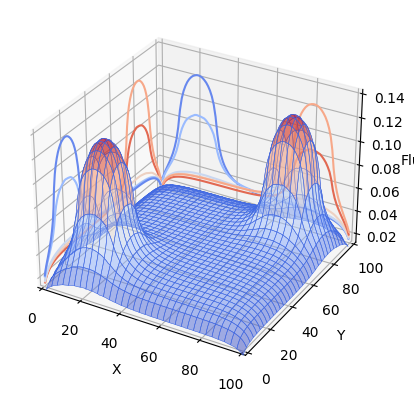

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')
X, Y = np.meshgrid(x_i,y_j)
X= np.transpose(X)
Y = np.transpose(Y)

Z = flux_new

# Plot the 3D surface

ax.contour(X, Y, Z, offset=00, zdir='x', cmap='coolwarm')
ax.contour(X, Y, Z , offset=100, zdir='y', cmap='coolwarm')
surf = ax.plot_surface(X, Y, Z,cmap='coolwarm', edgecolor='royalblue', lw=0.4, rstride=3, cstride=3,
                alpha=0.5)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.

ax.set(xlim = (0, 100), ylim=(0,100), zlim=(0.015, 0.141),
    xlabel='X', ylabel='Y', zlabel='Flux')
#fig.colorbar(surf)

plt.show()

